This notebook aims to inspect the sklearn decision tree functionalities.

In [5]:
import sklearn.datasets as datasets
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [6]:
# load dataset and get data frame, X and y
iris=datasets.load_iris()
df=pd.DataFrame(iris.data, columns=iris.feature_names)
y=iris.target

# create full data set 
iris_df = df.join(pd.Series(y, name='target'))

# change target names of iris
target_name_dict = {0:'setosa',
                   1:'versicolor',
                   2:'virginica'}

def convert_target(df, target_name_dict):
    """
    function to change target names to the given target names
    """
    df['target'] = df['target'].astype(str)
    for old_label, new_label in target_name_dict.items():
        df.loc[df['target']==str(old_label), 'target'] = new_label
    return df

#iris_df = convert_target(iris_df, target_name_dict)

# create train and test stratified split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(iris_df, test_size=0.3, stratify=iris_df.target)

#### descriptive statistics

In [7]:
# print first rows
df_train.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
10,5.4,3.7,1.5,0.2,0
14,5.8,4.0,1.2,0.2,0
6,4.6,3.4,1.4,0.3,0
147,6.5,3.0,5.2,2.0,2
146,6.3,2.5,5.0,1.9,2


In [8]:
# check the frequency of target values
Counter(df_train.target)

Counter({0: 35, 2: 35, 1: 35})

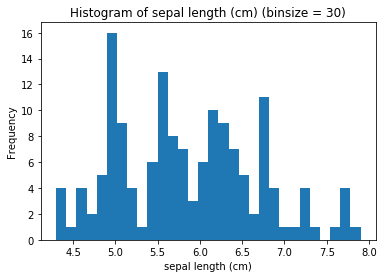

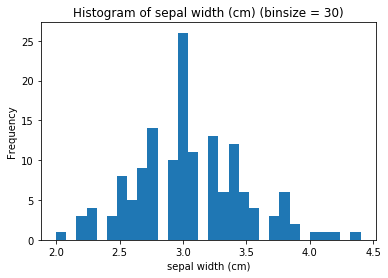

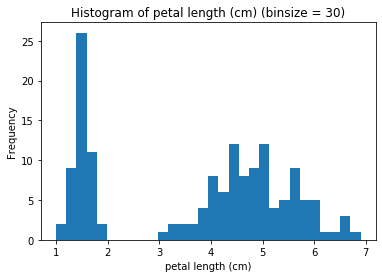

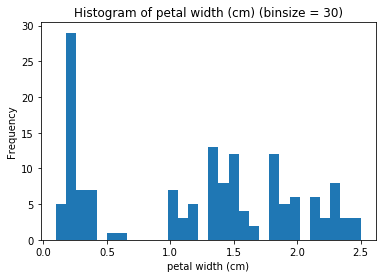

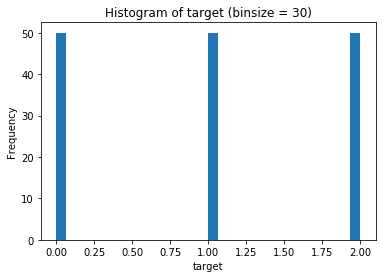

In [9]:
def plot_hist(df, col, bin_size=10):
    """
    function to plot histograms of colummns
    """
    plt.hist(df[col], bins = bin_size)
    plt.title(f'Histogram of {df[col].name} (binsize = {bin_size})')
    plt.xlabel(df[col].name)
    plt.ylabel('Frequency')
    plt.show()

# plot histograms of variables
for col_names in iris_df.columns:
    plot_hist(iris_df, col=col_names, bin_size=30)

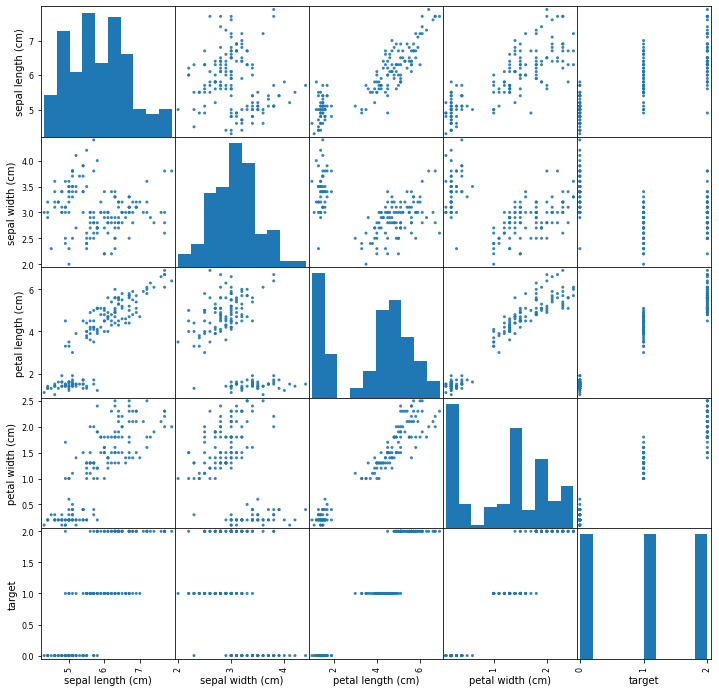

In [10]:
from pandas.plotting import scatter_matrix
scatter_plot = scatter_matrix(iris_df, figsize=(12, 12), alpha=0.9)

translation of variables \
\
petal = bluetenblatt \
sepal = Kelchblatt

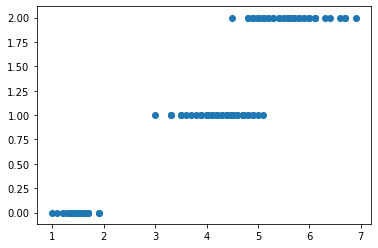

In [11]:
plt.scatter(iris_df['petal length (cm)'], iris_df['target'])

In [12]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth=4)
dtree.fit(df,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
# evaluate decision tree
X_test = df_test.drop(labels='target', axis=1)
y_test = df_test.target

y_pred = dtree.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[15,  0,  0],
       [ 0, 15,  0],
       [ 0,  0, 15]], dtype=int64)

##### results description

The decision tree reaches an accuracy of 100%.
For that, it is needed to have a decision tree with depth of 4.

In [14]:
# explore decision tree
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

C:\Users\Stefan\Anaconda3\envs\iris_classification\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [15]:
# TODO: get graphviz and plot decision tree

In [16]:
# graphviz
from IPython.display import display
display(graphviz.Source(dot_data))

from IPython.display import Image  

import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NameError: name 'graphviz' is not defined